# 8.1.1 Deep Neural Networks

## Preparation

In [1]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(2)

## Neural Network Module and Training Function

In [11]:
# Define a sigmoid model class
class Net(nn.Module):
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    #Prediction
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x

In [12]:
# Define a Tanh model class
class Net_Tanh(nn.Module):
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(Net_Tanh, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    #Prediction
    def forward(self,x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = self.linear3(x)
        return x

In [37]:
# Define a ReLu model class
class Net_ReLu(nn.Module):
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(Net_ReLu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    #Prediction
    def forward(self,x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

## Make Data

In [14]:
# Create the training dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, 
                            transform=transforms.ToTensor())

# Create the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, 
                                 transform=transforms.ToTensor())

In [15]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

In [16]:
# Create the training data loader and validation data loader object

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=5000, shuffle=False)

## Train the Data

In [11]:
# Class a training model
def train(model, criterion, train_loader, valdation_loader, optimizer, epochs=100):
    i = 0
    useful_data = {'Training_loss': [],
                  'Validation_accuracy': []}
    
    for epoch in range(epochs):
        for x, y in train_loader:
            # Zero the optimizer
            optimizer.zero_grad()
            
            #Prediction
            z = model(x.view(-1, 28*28))
            loss = criterion(z, y)
            
            #update
            loss.backward()
            optimizer.step()
            useful_data['Training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in valdation_loader:
            z = model(x.view(-1, 28*28))
            _, label = torch.max(z, 1)
            correct += (label==y).sum().item()
        
        accuracy = 100 * (correct / len(validation_dataset))
        useful_data['Validation_accuracy'].append(accuracy)
        
    return useful_data

In [12]:
# Create a Sigmoid model
model = Net(28*28, 50, 50, 10)

# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

TypeError: __init__() takes 2 positional arguments but 5 were given

In [13]:
# Train the Sigmoid model
train_sig = train(model, criterion, train_loader, validation_loader, optimizer, epochs=35)

NameError: name 'validation_loader' is not defined

In [24]:
# Create a Tanh model
model_tanh = Net_Tanh(28*28, 50, 50, 10)

# Create the optimizer
optimizer = optim.SGD(model_tanh.parameters(), lr = 0.01)

In [25]:
# Train the sigmoid model
train_tanh = train(model_tanh, criterion, train_loader, validation_loader, optimizer, epochs=35)

In [38]:
# Create a ReLu model
model_relu = Net_ReLu(28*28, 50, 50, 10)

# Create the optimizer
optimizer = optim.SGD(model_relu.parameters(), lr = 0.01)

In [39]:
# Train the ReLu model
train_relu = train(model_relu, criterion, train_loader, validation_loader, optimizer, epochs=35)

## Analyze Results

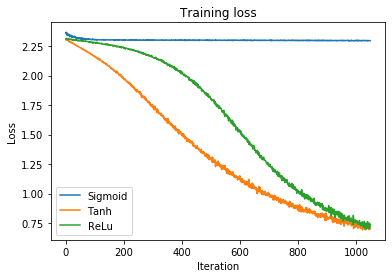

In [40]:
# Compare the Training loss

plt.plot(train_sig['Training_loss'], label = 'Sigmoid')
plt.plot(train_tanh['Training_loss'], label = 'Tanh')
plt.plot(train_relu['Training_loss'], label = 'ReLu')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Training loss')
plt.legend()

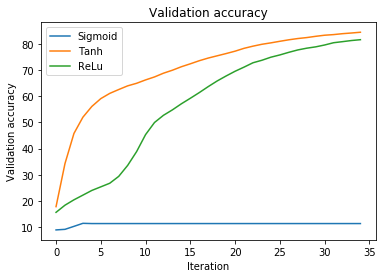

In [41]:
# Compare the Validation accuracy

plt.plot(train_sig['Validation_accuracy'], label = 'Sigmoid')
plt.plot(train_tanh['Validation_accuracy'], label = 'Tanh')
plt.plot(train_relu['Validation_accuracy'], label = 'ReLu')
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.title('Validation accuracy')
plt.legend()

# 8.1.2 Deeper Neural Networks : nn.ModuleList()

## Preparation

In [1]:
# Import the libraries we need for this lab

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [2]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [3]:
# Create Data Class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

## Neural Network Module and Function for Training

In [5]:
# Class a Net model class
class Net(nn.Module):
     # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        
        for input_size, output_size in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for l, linear_transform in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            
            else: 
                activation = linear_transform(activation)
        
        return activation

In [6]:
# Create a model
layers = [2, 3, 4, 3]
model = Net(layers)

In [14]:
# Define a training function
def train(model, data_set, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            LOSS.append(loss.data.item())
        
        _, yhat = torch.max(model(data_set.x), 1)
        ACC.append((yhat == data_set.y).numpy().mean())
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

## Train and Validate the Model

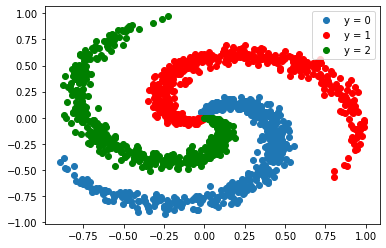

In [15]:
# Create a dataset
data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

In [16]:
# Create the model
layers = [2, 50, 3]
model = Net(layers)

# Define the learning rate
learning_rate = 0.1

# Create the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Create the loss function
criterion = nn.CrossEntropyLoss()

# Create the trainloader
train_loader = DataLoader(data_set, batch_size=20)

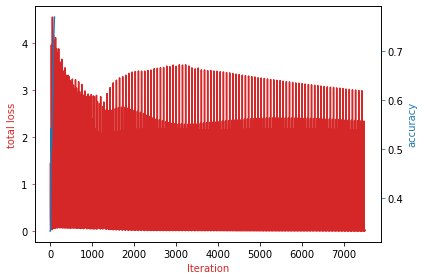

In [17]:
# train the model
LOSS = train(model, data_set, criterion, train_loader, optimizer, epochs=100)

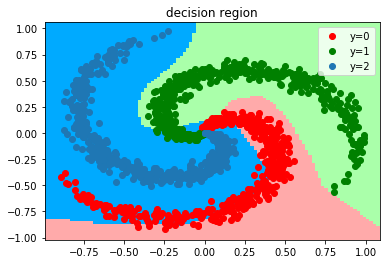

In [18]:
# Plot the region
plot_decision_regions_3class(model, data_set)

In [25]:
# Create a model with 2 hidden layers with 20 neurons
layers = [2, 20, 20, 3]
model = Net(layers)

# Define the learning rate
learning_rate = 0.1

# Create the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Create the loss function
criterion = nn.CrossEntropyLoss()

# Create the trainloader
train_loader = DataLoader(data_set, batch_size=20)

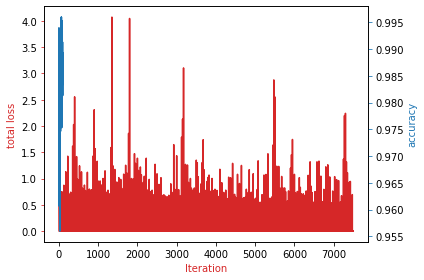

In [28]:
# train the model
LOSS = train(model, data_set, criterion, train_loader, optimizer, epochs=100)

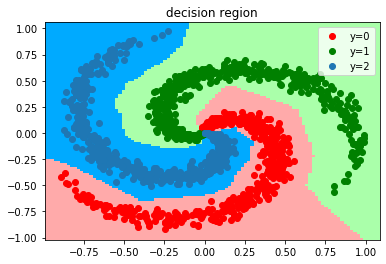

In [27]:
# Plot the region
plot_decision_regions_3class(model, data_set)

In [35]:
# Create a model with 3 hidden layers with 10 neurons
layers = [2, 10, 10, 10, 3]
model = Net(layers)

# Define the learning rate
learning_rate = 0.01

# Create the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Create the loss function
criterion = nn.CrossEntropyLoss()

# Create the trainloader
train_loader = DataLoader(data_set, batch_size=20)

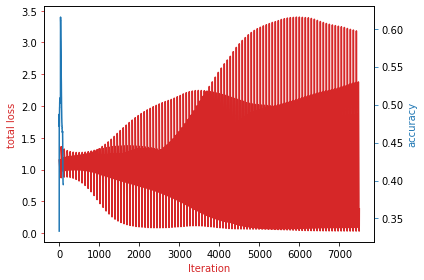

In [36]:
# train the model
LOSS = train(model, data_set, criterion, train_loader, optimizer, epochs=100)

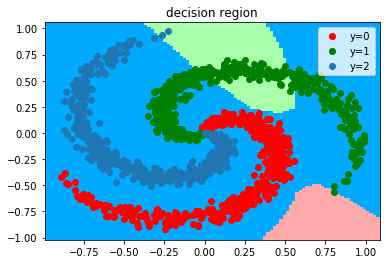

In [37]:
# Plot the region
plot_decision_regions_3class(model, data_set)